In [1]:
# Env
import os
from dotenv import load_dotenv

if not load_dotenv() or 'HOPSWORKS_API_KEY' not in os.environ:
    print("Please provide a .env file add HOPSWORKS_API_KEY to it.")
    exit(1)

# Imports
import hopsworks
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
from matplotlib import pyplot
from hsml.schema import Schema
from hsml.model_schema import ModelSchema
import joblib
import os
import numpy as np

# IDE help
from hsfs import feature_store, feature_group, feature_view
from hsfs.constructor import query as hsfs_query

# Settings
# - Hopsworks
hopsworks_api_key_modal_secret_name = "hopsworks-api-key"  # Load secret to environment
hopsworks_images_location = "Resources/images"
# - - Names
# - - - Models
model_wine_dir = "wine_models"
model_red_wine_name = "wine_red_model"
model_red_wine_version = 1
model_white_wine_name = "wine_white_model"
model_white_wine_version = 1
# - Feature Groups
fg_wine_name = "wine"
fg_wine_version = 1
fg_type_red = "red"
fg_type_white = "white"
# - - - Feature Views
fw_wine_red_name = "wine_red"
fw_wine_red_version = 1
fw_wine_white_name = "wine_white"
fw_wine_white_version = 1
# - - - Monitor
fg_monitor_name = "wine_predictions"
fg_monitor_version = 1
dir_wine_saves = "./latest_wine"
# file_wine_predict_save = f"{dir_wine_saves}/latest_wine.png"  # Don't know of a good picture for a rating
# file_wine_actual_save = f"{dir_wine_saves}/actual_wine.png"  # Don't know of a good picture for a rating
file_dataframe_save = f"{dir_wine_saves}/df_recent.png"
file_confusion_matrix_save = f"{dir_wine_saves}/confusion_matrix.png"
num_monitor_entries_to_export = 4

In [2]:
# Log in to Hopsworks and get feature store
project = hopsworks.login()
fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/201877
Connected. Call `.close()` to terminate connection gracefully.


In [3]:
wine_fg: feature_group.FeatureGroup = fs.get_feature_group(name=fg_wine_name, version=fg_wine_version)

try:
    wine_red_fw: feature_view.FeatureView = fs.get_feature_view(name=fw_wine_red_name)
    print("Red Wine fw exists.")
except Exception as e:
    print("Red Wine fw must be created.")
    wine_red_query: hsfs_query.Query = wine_fg.select_all()
    wine_red_query.filter(wine_red_query["type"] == fg_type_red)
    wine_red_fw: feature_view.FeatureView = (
        fs.get_or_create_feature_view(
            name=fw_wine_red_name,
            version=fw_wine_red_version,
            description="Read red wines from wine dataset",
            labels=["quality", "type"],
            query=wine_red_query))
    
try:
    wine_white_fw: feature_view.FeatureView = fs.get_feature_view(name=fw_wine_white_name)
    print("White Wine fw exists.")
except Exception as e:
    print("White Wine fw must be created.")
    wine_white_query: hsfs_query.Query = wine_fg.select_all()
    wine_white_query.filter(wine_white_query["type"] == fg_type_white)
    wine_white_fw: feature_view.FeatureView = (
        fs.get_or_create_feature_view(
            name=fw_wine_white_name,
            version=fw_wine_white_version,
            description="Read from Wine dataset",
            labels=["quality", "type"],
            query=wine_white_query))


Red Wine fw exists.


White Wine fw exists.


# Inspect Feature Views

In [4]:
wine_red_fw.features

[Training Dataset Feature('type', 'string', 0, True, None, None, 236925),
 Training Dataset Feature('fixed_acidity', 'double', 1, False, None, None, 236925),
 Training Dataset Feature('volatile_acidity', 'double', 2, False, None, None, 236925),
 Training Dataset Feature('citric_acid', 'double', 3, False, None, None, 236925),
 Training Dataset Feature('residual_sugar', 'double', 4, False, None, None, 236925),
 Training Dataset Feature('chlorides', 'double', 5, False, None, None, 236925),
 Training Dataset Feature('free_sulfur_dioxide', 'double', 6, False, None, None, 236925),
 Training Dataset Feature('total_sulfur_dioxide', 'double', 7, False, None, None, 236925),
 Training Dataset Feature('density', 'double', 8, False, None, None, 236925),
 Training Dataset Feature('ph', 'double', 9, False, None, None, 236925),
 Training Dataset Feature('sulphates', 'double', 10, False, None, None, 236925),
 Training Dataset Feature('alcohol', 'double', 11, False, None, None, 236925),
 Training Datase

In [5]:
wine_red_fw.description

'Read red wines from wine dataset'

In [6]:
wine_red_fw.query.read()

Finished: Reading data from Hopsworks, using ArrowFlight (0.99s) 


,type,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,quality
0,red,8.8,0.37,0.48,2.1,0.097,39.0,145.0,0.99750,3.04,1.03,9.3,5
1,red,8.8,0.59,0.18,2.9,0.089,12.0,74.0,0.99738,3.14,0.54,9.4,5
2,red,6.8,0.64,0.03,2.3,0.075,14.0,31.0,0.99545,3.36,0.58,10.4,6
3,red,6.3,0.68,0.01,3.7,0.103,32.0,54.0,0.99586,3.51,0.66,11.3,6
4,red,6.9,0.49,0.19,1.7,0.079,13.0,26.0,0.99547,3.38,0.64,9.8,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1352,red,12.5,0.56,0.49,2.4,0.064,5.0,27.0,0.99990,3.08,0.87,10.9,5
1353,red,9.1,0.30,0.41,2.0,0.068,10.0,24.0,0.99523,3.27,0.85,11.7,7
1354,red,11.7,0.45,0.63,2.2,0.073,7.0,23.0,0.99974,3.21,0.69,10.9,6
1355,red,8.1,0.72,0.09,2.8,0.084,18.0,49.0,0.99940,3.43,0.72,11.1,6


In [7]:
wine_white_fw.query.read()

Finished: Reading data from Hopsworks, using ArrowFlight (0.74s) 


,type,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol,quality
0,white,6.800000,0.210000,0.550000,14.600000,0.053000,34.000000,159.000000,0.998050,2.930000,0.440000,9.200000,5
1,white,7.000000,0.390000,0.310000,5.300000,0.169000,32.000000,162.000000,0.996500,3.200000,0.480000,9.400000,5
2,white,6.300000,0.230000,0.330000,1.500000,0.036000,15.000000,105.000000,0.991000,3.320000,0.420000,11.200000,6
3,white,7.000000,0.290000,0.370000,4.900000,0.034000,26.000000,127.000000,0.992800,3.170000,0.440000,10.800000,6
4,white,7.300000,0.240000,0.430000,2.000000,0.021000,20.000000,69.000000,0.990000,3.080000,0.560000,12.200000,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3958,white,6.600000,0.220000,0.350000,1.400000,0.050000,23.000000,83.000000,0.990190,3.170000,0.480000,12.000000,7
3959,white,6.500000,0.430000,0.180000,13.150000,0.032000,25.000000,131.000000,0.995650,3.230000,0.510000,10.700000,5
3960,white,8.800000,0.360000,0.440000,1.900000,0.040000,9.000000,121.000000,0.995300,3.190000,0.480000,9.900000,6
3961,white,5.784863,0.306600,0.355189,5.189500,0.056228,49.505870,122.875310,0.995321,3.146847,0.541047,12.600989,6


# Training

## Red Wine

In [8]:
# You can read training data, randomly split into train/test sets of features (X) and labels (y)        
wine_red_X_train, wine_red_X_test, wine_red_y_train, wine_red_y_test = wine_red_fw.train_test_split(0.2)
wine_red_y_train = wine_red_y_train.drop(columns=["type"])
wine_red_y_test = wine_red_y_test.drop(columns=["type"])

# I've tried so many different models. Let's just use RandomForestClassifier at this point... At least there is wisdom in the crowd.
model_red_wine = RandomForestClassifier()
model_red_wine.fit(wine_red_X_train, wine_red_y_train.values.ravel())

Finished: Reading data from Hopsworks, using ArrowFlight (0.88s) 


RandomForestClassifier()

In [9]:
wine_red_X_train

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol
1,8.8,0.59,0.18,2.9,0.089,12.0,74.0,0.99738,3.14,0.54,9.4
2,6.8,0.64,0.03,2.3,0.075,14.0,31.0,0.99545,3.36,0.58,10.4
3,6.3,0.68,0.01,3.7,0.103,32.0,54.0,0.99586,3.51,0.66,11.3
4,6.9,0.49,0.19,1.7,0.079,13.0,26.0,0.99547,3.38,0.64,9.8
5,8.3,0.28,0.48,2.1,0.093,6.0,12.0,0.99408,3.26,0.62,12.4
...,...,...,...,...,...,...,...,...,...,...,...
1352,12.5,0.56,0.49,2.4,0.064,5.0,27.0,0.99990,3.08,0.87,10.9
1353,9.1,0.30,0.41,2.0,0.068,10.0,24.0,0.99523,3.27,0.85,11.7
1354,11.7,0.45,0.63,2.2,0.073,7.0,23.0,0.99974,3.21,0.69,10.9
1355,8.1,0.72,0.09,2.8,0.084,18.0,49.0,0.99940,3.43,0.72,11.1


In [10]:
wine_red_y_train

,quality
1,5
2,6
3,6
4,6
5,7
...,...
1352,5
1353,7
1354,6
1355,6


In [11]:
# Evaluate model performance using the features from the test set (X_test)
wine_red_y_pred = model_red_wine.predict(wine_red_X_test)

# Compare predictions (y_pred) with the labels in the test set (y_test)
wine_red_metrics = classification_report(wine_red_y_test, wine_red_y_pred, output_dict=True)
wine_red_results = confusion_matrix(wine_red_y_test, wine_red_y_pred)
wine_red_accuracy = accuracy_score(wine_red_y_test, wine_red_y_pred)

In [12]:
wine_red_metrics

{'3': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 2},
 '4': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 11},
 '5': {'precision': 0.7016129032258065,
  'recall': 0.7131147540983607,
  'f1-score': 0.7073170731707318,
  'support': 122},
 '6': {'precision': 0.5081967213114754,
  'recall': 0.62,
  'f1-score': 0.5585585585585586,
  'support': 100},
 '7': {'precision': 0.52,
  'recall': 0.37142857142857144,
  'f1-score': 0.43333333333333335,
  'support': 35},
 '8': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 2},
 'accuracy': 0.5955882352941176,
 'macro avg': {'precision': 0.28830160408954697,
  'recall': 0.2840905542544887,
  'f1-score': 0.283201494177104,
  'support': 272},
 'weighted avg': {'precision': 0.5684428173702055,
  'recall': 0.5955882352941176,
  'f1-score': 0.5783647259167345,
  'support': 272}}

#### Error rate

In [13]:
# Calculate the total number of misclassified samples
wine_red_total_errors = (wine_red_y_test.values.ravel() != wine_red_y_pred).sum()
wine_red_total_predictions = len(wine_red_y_pred)
wine_red_error_rate = wine_red_total_errors / wine_red_total_predictions

# Print out the error details
print(f"Total errors: {wine_red_total_errors}")
print(f"Error rate: {wine_red_error_rate:.2%}")
print(f"Accuracy: {wine_red_accuracy:.2%}")

Total errors: 110
Error rate: 40.44%
Accuracy: 59.56%


#### Confusion matrix

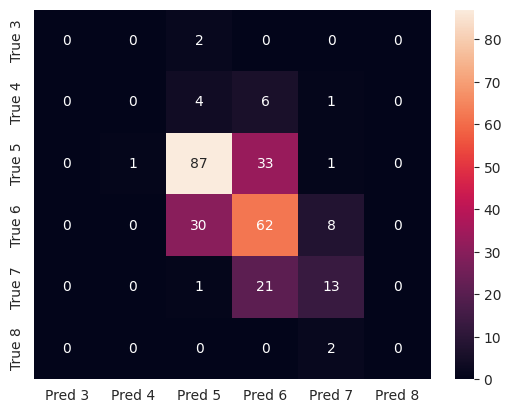

In [14]:
# Create the confusion matrix as a figure, we will later store it as a PNG image file
wine_red_true = [f"True {prediction}" for prediction in wine_red_metrics if prediction not in ['accuracy', 'macro avg', 'weighted avg']]
wine_red_pred = [f"Pred {prediction}" for prediction in wine_red_metrics if prediction not in ['accuracy', 'macro avg', 'weighted avg']]

wine_red_df_cm = pd.DataFrame(wine_red_results, wine_red_true, wine_red_pred)
wine_red_cm = sns.heatmap(wine_red_df_cm, annot=True)
wine_red_fig = wine_red_cm.get_figure()

## White Wine

In [15]:
# You can read training data, randomly split into train/test sets of features (X) and labels (y)        
wine_white_X_train, wine_white_X_test, wine_white_y_train, wine_white_y_test = wine_white_fw.train_test_split(0.2)
wine_white_y_train = wine_white_y_train.drop(columns=["type"])
wine_white_y_test = wine_white_y_test.drop(columns=["type"])

# I've tried so many different models. Let's just use RandomForestClassifier at this point... At least there is wisdom in the crowd.
model_white_wine = RandomForestClassifier()
model_white_wine.fit(wine_white_X_train, wine_white_y_train.values.ravel())

display(wine_white_X_train)
display(wine_white_y_test)

# Evaluate model performance using the features from the test set (X_test)
wine_white_y_pred = model_white_wine.predict(wine_white_X_test)

# Compare predictions (y_pred) with the labels in the test set (y_test)
wine_white_metrics = classification_report(wine_white_y_test, wine_white_y_pred, output_dict=True)
wine_white_results = confusion_matrix(wine_white_y_test, wine_white_y_pred)
wine_white_accuracy = accuracy_score(wine_white_y_test, wine_white_y_pred)

display(wine_white_metrics)

# Evaluate model performance using the features from the test set (X_test)
wine_white_y_pred = model_white_wine.predict(wine_white_X_test)

# Compare predictions (y_pred) with the labels in the test set (y_test)
wine_white_metrics = classification_report(wine_white_y_test, wine_white_y_pred, output_dict=True)
wine_white_results = confusion_matrix(wine_white_y_test, wine_white_y_pred)
wine_white_accuracy = accuracy_score(wine_white_y_test, wine_white_y_pred)

# Calculate the total number of misclassified samples
wine_white_total_errors = (wine_white_y_test.values.ravel() != wine_white_y_pred).sum()
wine_white_total_predictions = len(wine_white_y_pred)
wine_white_error_rate = wine_white_total_errors / wine_white_total_predictions

# Print out the error details
print(f"Total errors: {wine_white_total_errors}")
print(f"Error rate: {wine_white_error_rate:.2%}")
print(f"Accuracy: {wine_white_accuracy:.2%}")

Finished: Reading data from Hopsworks, using ArrowFlight (1.01s) 


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,ph,sulphates,alcohol
0,6.800000,0.210000,0.550000,14.600000,0.053000,34.000000,159.000000,0.998050,2.930000,0.440000,9.200000
1,7.000000,0.390000,0.310000,5.300000,0.169000,32.000000,162.000000,0.996500,3.200000,0.480000,9.400000
2,6.300000,0.230000,0.330000,1.500000,0.036000,15.000000,105.000000,0.991000,3.320000,0.420000,11.200000
3,7.000000,0.290000,0.370000,4.900000,0.034000,26.000000,127.000000,0.992800,3.170000,0.440000,10.800000
4,7.300000,0.240000,0.430000,2.000000,0.021000,20.000000,69.000000,0.990000,3.080000,0.560000,12.200000
...,...,...,...,...,...,...,...,...,...,...,...
3958,6.600000,0.220000,0.350000,1.400000,0.050000,23.000000,83.000000,0.990190,3.170000,0.480000,12.000000
3959,6.500000,0.430000,0.180000,13.150000,0.032000,25.000000,131.000000,0.995650,3.230000,0.510000,10.700000
3960,8.800000,0.360000,0.440000,1.900000,0.040000,9.000000,121.000000,0.995300,3.190000,0.480000,9.900000
3961,5.784863,0.306600,0.355189,5.189500,0.056228,49.505870,122.875310,0.995321,3.146847,0.541047,12.600989


,quality
6,6
11,6
18,6
19,5
21,4
...,...
3937,5
3940,7
3941,6
3947,6


{'3': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 2},
 '4': {'precision': 0.5,
  'recall': 0.15625,
  'f1-score': 0.23809523809523808,
  'support': 32},
 '5': {'precision': 0.6438356164383562,
  'recall': 0.5826446280991735,
  'f1-score': 0.6117136659436008,
  'support': 242},
 '6': {'precision': 0.5521739130434783,
  'recall': 0.7426900584795322,
  'f1-score': 0.6334164588528679,
  'support': 342},
 '7': {'precision': 0.5294117647058824,
  'recall': 0.3673469387755102,
  'f1-score': 0.4337349397590361,
  'support': 147},
 '8': {'precision': 0.5,
  'recall': 0.04,
  'f1-score': 0.07407407407407407,
  'support': 25},
 '9': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 3},
 'accuracy': 0.5737704918032787,
 'macro avg': {'precision': 0.3893458991696738,
  'recall': 0.26984737505060225,
  'f1-score': 0.28443348238925953,
  'support': 793},
 'weighted avg': {'precision': 0.5686951158268808,
  'recall': 0.5737704918032787,
  'f1-score': 0.5521980727635687,
 

Total errors: 338
Error rate: 42.62%
Accuracy: 57.38%


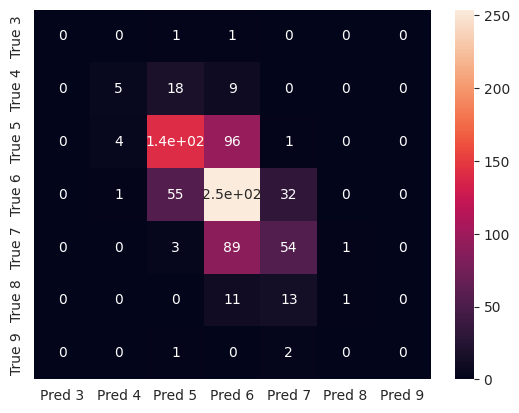

In [16]:
# Create the confusion matrix as a figure, we will later store it as a PNG image file
wine_white_true = [f"True {prediction}" for prediction in wine_white_metrics if prediction not in ['accuracy', 'macro avg', 'weighted avg']]
wine_white_pred = [f"Pred {prediction}" for prediction in wine_white_metrics if prediction not in ['accuracy', 'macro avg', 'weighted avg']]

wine_white_df_cm = pd.DataFrame(wine_white_results, wine_white_true, wine_white_pred)
wine_white_cm = sns.heatmap(wine_white_df_cm, annot=True)
wine_white_fig = wine_white_cm.get_figure()

# Upload

In [17]:
# We will now upload our model to the Hopsworks Model Registry. First get an object for the model registry.
mr = project.get_model_registry()

# Create the dir, first.
if not os.path.isdir(model_wine_dir):
    os.mkdir(model_wine_dir)

Connected. Call `.close()` to terminate connection gracefully.


In [19]:
# Save both our model and the confusion matrix to 'model_dir', whose contents will be uploaded to the model registry
joblib.dump(model_red_wine, model_wine_dir + f"/{model_red_wine_name}.pkl")
wine_red_fig.savefig(model_wine_dir + f"/confusion_matrix-{model_red_wine_name}.png")

# Specify the schema of the model's input/output using the features (X_train) and labels (y_train)
red_input_schema = Schema(wine_red_X_train)
red_output_schema = Schema(wine_red_y_train)
red_model_schema = ModelSchema(red_input_schema, red_output_schema)

# Create an entry in the model registry that includes the model's name, desc, metrics
red_wine_model = mr.python.create_model(
    name=model_red_wine_name, 
    metrics={"accuracy": wine_red_metrics['accuracy']},
    model_schema=red_model_schema,
    description="Red Wine Quality Predictor"
)

# Upload the model to the model registry, including all files in 'model_dir'
red_wine_model.save(model_wine_dir)

  0%|          | 0/6 [00:00<?, ?it/s]

Model created, explore it at https://c.app.hopsworks.ai:443/p/201877/models/wine_red_model/1


Model(name: 'wine_red_model', version: 1)

In [21]:
# Save both our model and the confusion matrix to 'model_dir', whose contents will be uploaded to the model registry
joblib.dump(model_white_wine, model_wine_dir + f"/{model_white_wine_name}.pkl")
wine_white_fig.savefig(model_wine_dir + f"/confusion_matrix-{model_white_wine_name}.png")

# Specify the schema of the model's input/output using the features (X_train) and labels (y_train)
white_input_schema = Schema(wine_white_X_train)
white_output_schema = Schema(wine_white_y_train)
white_model_schema = ModelSchema(white_input_schema, white_output_schema)

# Create an entry in the model registry that includes the model's name, desc, metrics
white_wine_model = mr.python.create_model(
    name=model_white_wine_name, 
    metrics={"accuracy": wine_white_metrics['accuracy']},
    model_schema=white_model_schema,
    description="White Wine Quality Predictor"
)

# Upload the model to the model registry, including all files in 'model_dir'
white_wine_model.save(model_wine_dir)

  0%|          | 0/6 [00:00<?, ?it/s]

Model created, explore it at https://c.app.hopsworks.ai:443/p/201877/models/wine_white_model/2


Model(name: 'wine_white_model', version: 2)